- ChatGPT has shown impressive capabilities in processing and generating human-like text. However, it is not without its imperfections. A primary concern is the model’s propensity to produce either inaccurate or obsolete answers, often called “hallucinations.”

- To address this, we can use an approach that focuses on augmenting ChatGPT using a knowledge graph. This method aims to provide a structured context, ensuring the model outputs are accurate but also relevant and up-to-date.

#### What is a knowledge graph?

A knowledge graph is a structured format of knowledge representation, usually composed of entities and relationships. In a typical knowledge graph, entities are the nodes, and the relationships between them are the edges.

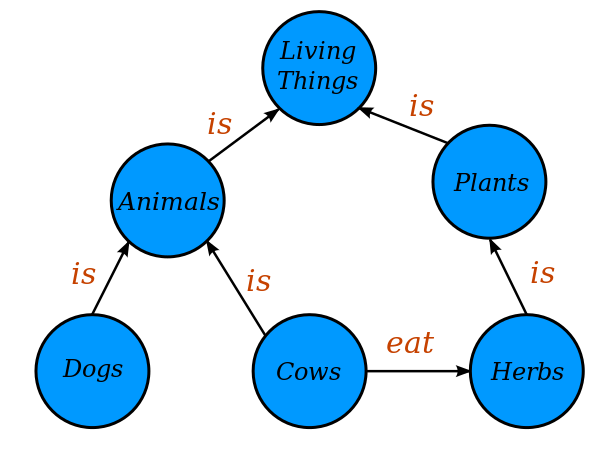

In [1]:
# !pip install openai langchain

import os
import openai

In [11]:
os.environ['OPENAI_API_KEY'] = ""
openai.api_key = os.environ['OPENAI_API_KEY']

In [2]:
question = "When did apple announced the Vision Pro?"
completion = openai.ChatCompletion.create(model="gpt-3.5-turbo",
                                          temperature=0,
                                          messages=[{"role": "user",
                                                     "content": question}])
print(completion["choices"][0]["message"]["content"])

I'm sorry, but I couldn't find any information about Apple announcing a product called "Vision Pro." It's possible that you may be referring to a different product or there may be a mistake in the name. Could you please provide more details or clarify your question?


#### Sentence-Level Knowledge Graphs

- GraphIndexCreator can parse a sentence and create a knowledge graph.
- By feeding a sentence into the GraphIndexCreator, it creates a knowledge graph by identifying the sentence’s entities and relationships, forming triplets of information in the format of (source node, relation, target node).

In [5]:
from langchain.llms import OpenAI
from langchain.indexes import GraphIndexCreator
from langchain.prompts import PromptTemplate, PipelinePromptTemplate
from langchain.chains import GraphQAChain

import networkx as nx
import matplotlib.pyplot as plt

In [12]:
text = "Apple announced the Vision Pro in 2023."

index_creator = GraphIndexCreator(llm = OpenAI(temperature=0))
graph = index_creator.from_text(text)

graph.get_triples()

[('Apple', 'Vision Pro', 'announced'),
 ('Vision Pro', '2023', 'was announced in')]

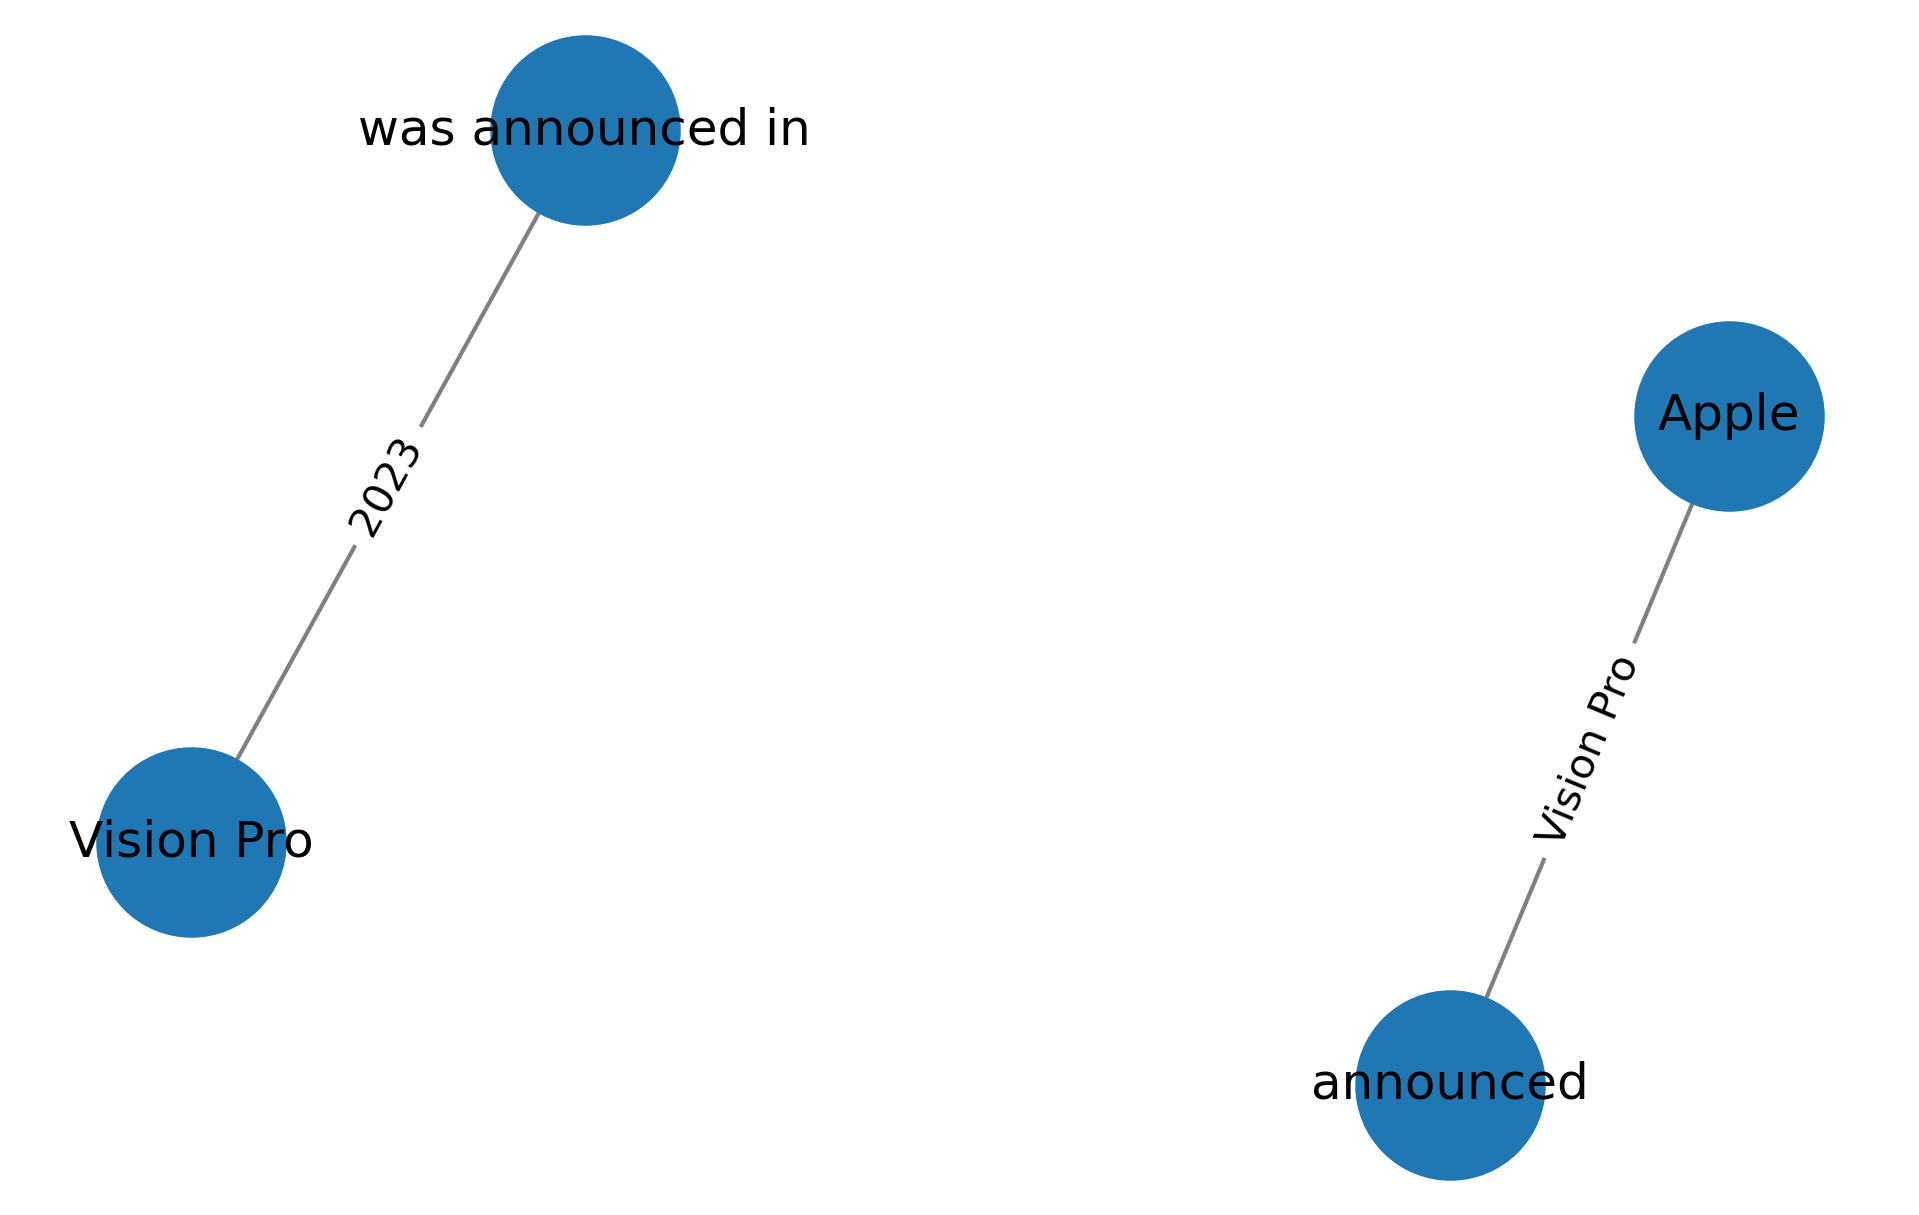

In [21]:
# Create graph
G = nx.DiGraph()
G.add_edges_from((source, target, {'relation': relation}) for source, relation, target in graph.get_triples())

# Plot the graph
plt.figure(figsize=(8,5), dpi=300)
pos = nx.spring_layout(G, k=3, seed=0)

nx.draw_networkx_nodes(G, pos, node_size=2000)
nx.draw_networkx_edges(G, pos, edge_color='gray')
nx.draw_networkx_labels(G, pos, font_size=12)
edge_labels = nx.get_edge_attributes(G, 'relation')
nx.draw_networkx_edge_labels(G, pos, edge_labels=edge_labels, font_size=10)

# Display the plot
plt.axis('off')
plt.show()

In [24]:
chain = GraphQAChain.from_llm(OpenAI(temperature=0), graph=graph, verbose=True)
chain.run(question)



> Entering new GraphQAChain chain...
Entities Extracted:
 Apple, Vision Pro
Full Context:
Apple announced Vision Pro
Vision Pro was announced in 2023

> Finished chain.


' Apple announced the Vision Pro in 2023.'

#### Bigger Knowledge Graphs

Create more complex graph by supplying a list of triplets to the GraphIndexCreator object using the add_triple() method. Each triplet represents a distinct piece of knowledge related to Apple, such as products it has created or where it is located.

In [37]:
from langchain.graphs.networkx_graph import KnowledgeTriple

In [25]:
kg = [
    ('Apple', 'is', 'Company'),
    ('Apple', 'created', 'iMac'),
    ('Apple', 'created', 'iPhone'),
    ('Apple', 'created', 'Apple Watch'),
    ('Apple', 'created', 'Vision Pro'),

    ('Apple', 'developed', 'macOS'),
    ('Apple', 'developed', 'iOS'),
    ('Apple', 'developed', 'watchOS'),

    ('Apple', 'is located in', 'USA'),
    ('Steve Jobs', 'co-founded', 'Apple'),
    ('Steve Wozniak', 'co-founded', 'Apple'),
    ('Tim Cook', 'is the CEO of', 'Apple'),

    ('iOS', 'runs on', 'iPhone'),
    ('macOS', 'runs on', 'iMac'),
    ('watchOS', 'runs on', 'Apple Watch'),

    ('Apple', 'was founded in', '1976'),
    ('Apple', 'owns', 'App Store'),
    ('App Store', 'sells', 'iOS apps'),

    ('iPhone', 'announced in', '2007'),
    ('iMac', 'announced in', '1998'),
    ('Apple Watch', 'announced in', '2014'),
    ('Vision Pro', 'announced in', '2023'),
]

In [27]:
graph = index_creator.from_text('')
for (node1, relation, node2) in kg:
    graph.add_triple(KnowledgeTriple(node1, relation, node2))
    
graph.get_triples()

[('Apple', 'Company', 'is'),
 ('Apple', 'iMac', 'created'),
 ('Apple', 'iPhone', 'created'),
 ('Apple', 'Apple Watch', 'created'),
 ('Apple', 'Vision Pro', 'created'),
 ('Apple', 'macOS', 'developed'),
 ('Apple', 'iOS', 'developed'),
 ('Apple', 'watchOS', 'developed'),
 ('Apple', 'USA', 'is located in'),
 ('Apple', '1976', 'was founded in'),
 ('Apple', 'App Store', 'owns'),
 ('iMac', '1998', 'announced in'),
 ('iPhone', '2007', 'announced in'),
 ('Apple Watch', '2014', 'announced in'),
 ('Vision Pro', '2023', 'announced in'),
 ('macOS', 'iMac', 'runs on'),
 ('iOS', 'iPhone', 'runs on'),
 ('watchOS', 'Apple Watch', 'runs on'),
 ('Steve Jobs', 'Apple', 'co-founded'),
 ('Steve Wozniak', 'Apple', 'co-founded'),
 ('Tim Cook', 'Apple', 'is the CEO of'),
 ('App Store', 'iOS apps', 'sells')]

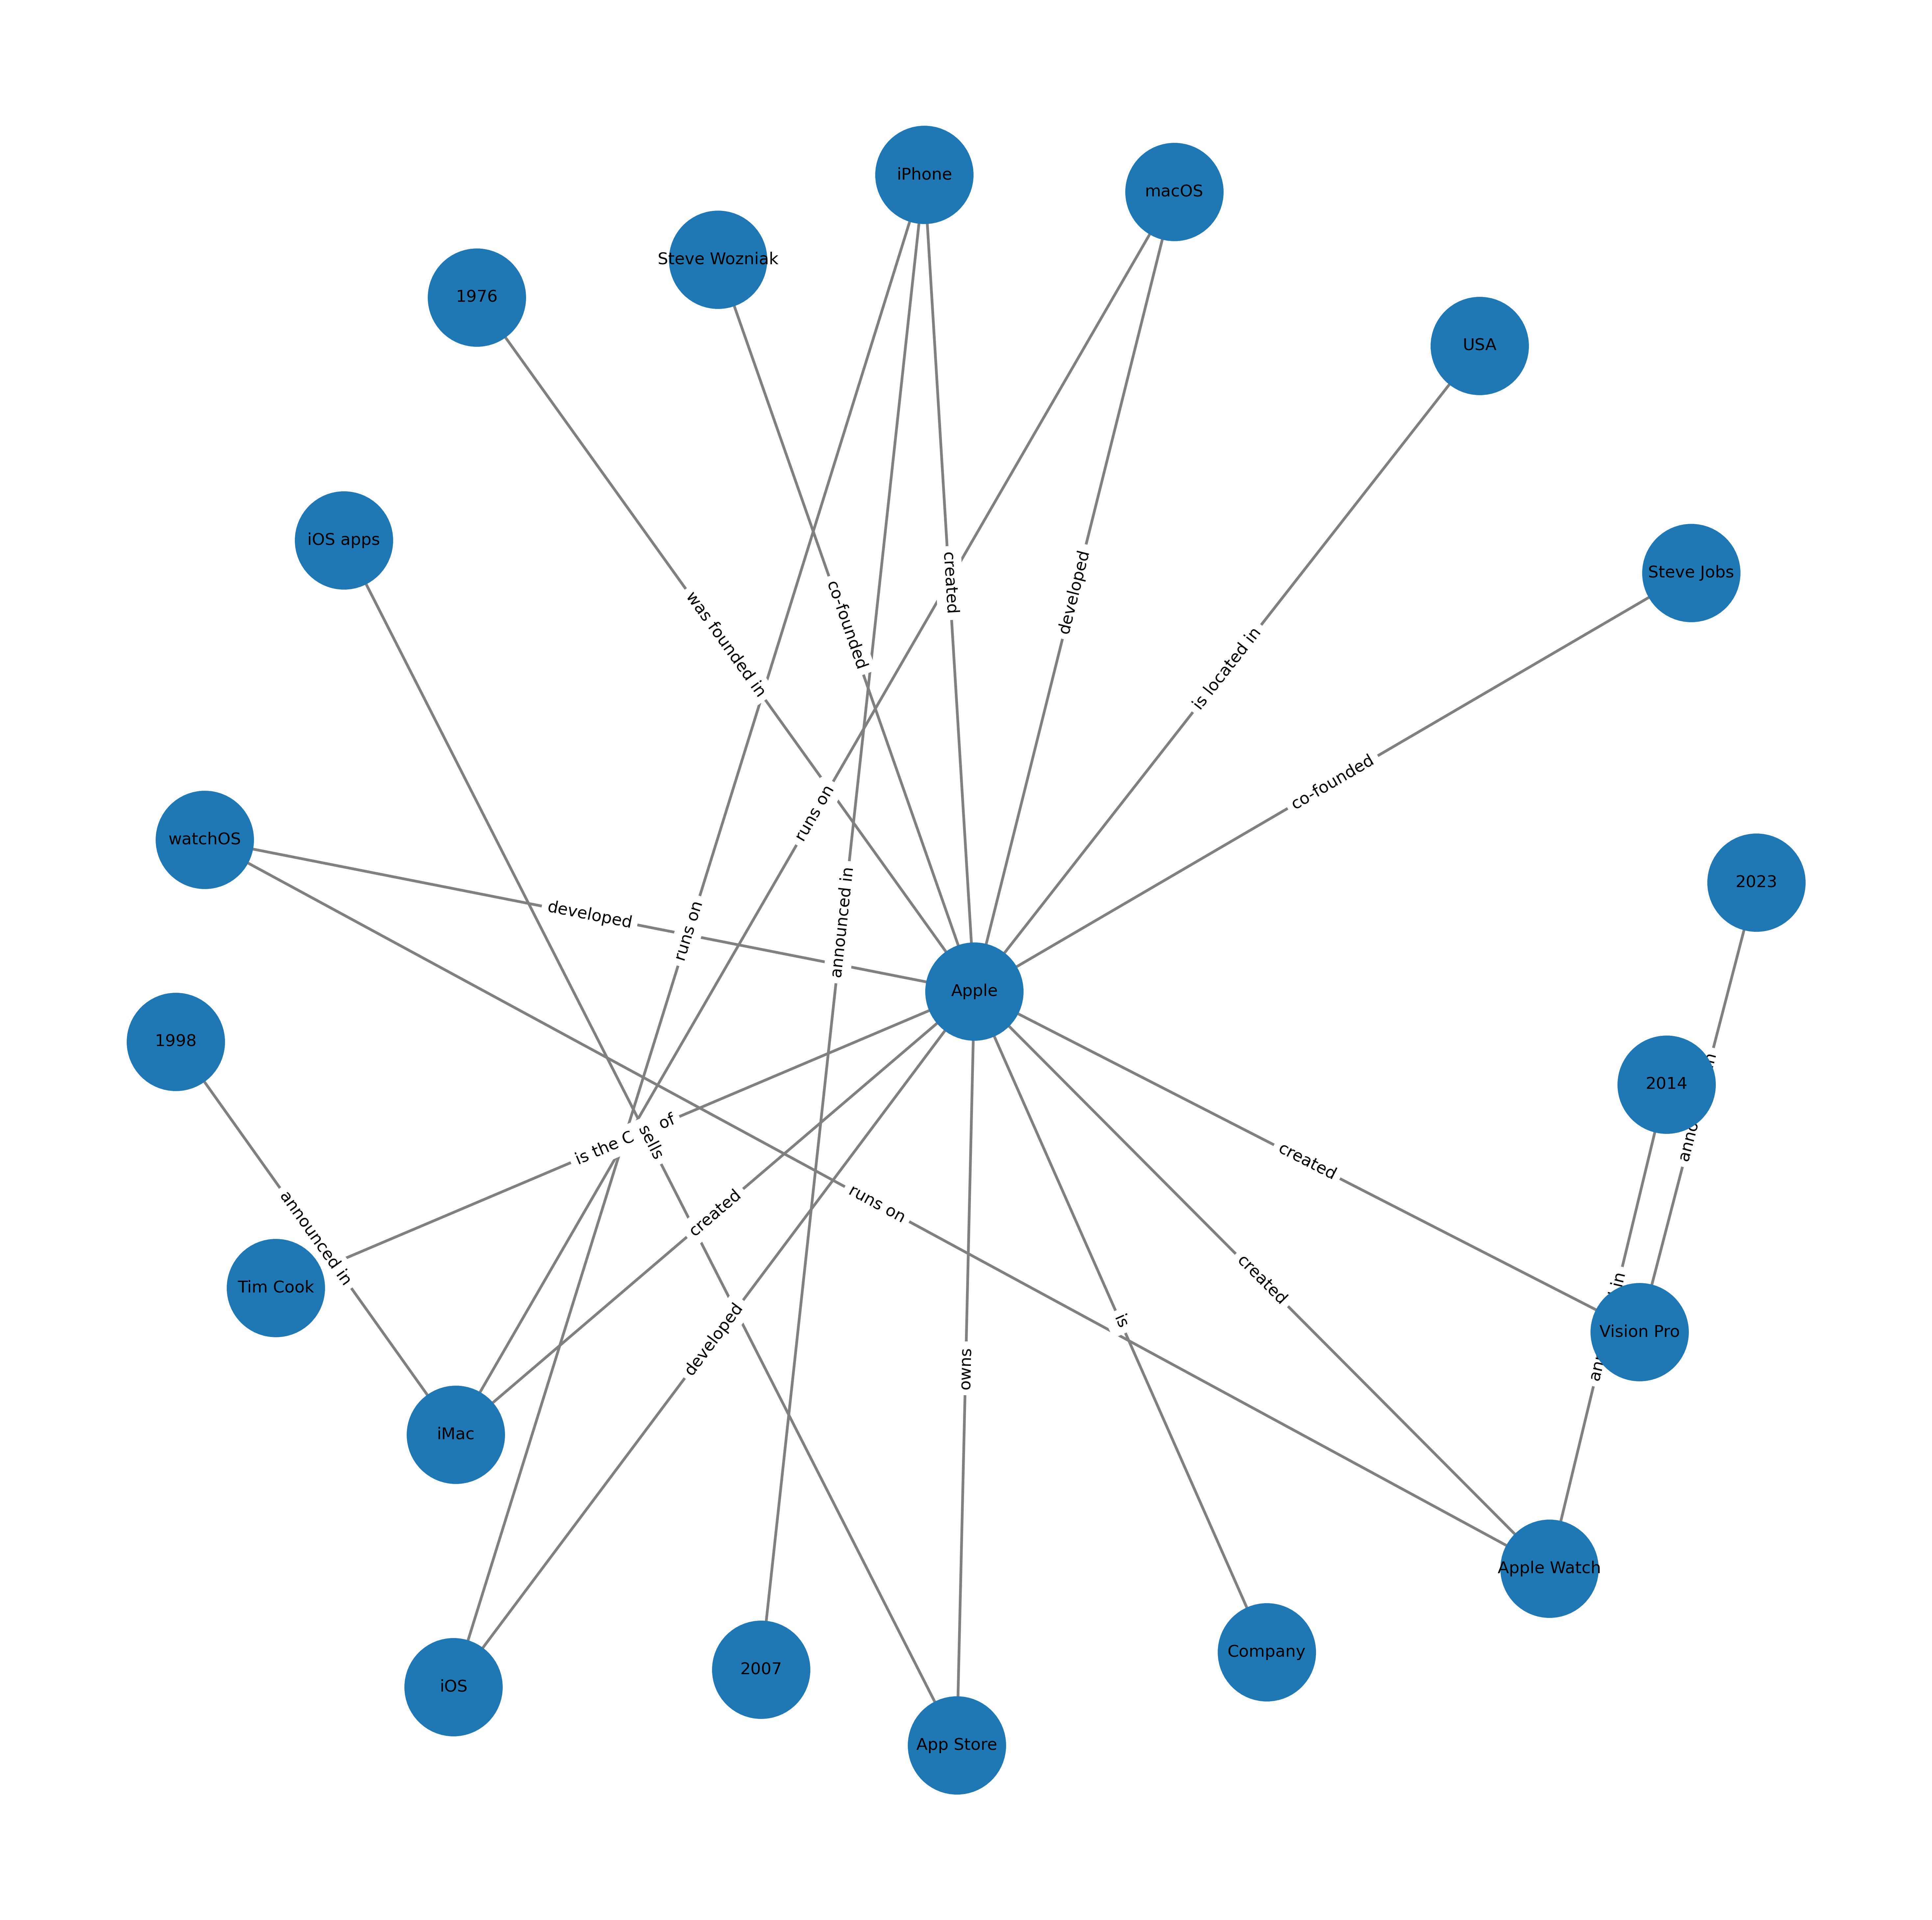

In [34]:
G = nx.DiGraph()
for node1, relation, node2 in kg:
    G.add_edge(node1, node2, label=relation)
    
# G.add_edges_from((source, target, {'relation': relation}) for source, relation, target in graph.get_triples())

# Plot the graph
plt.figure(figsize=(25, 25), dpi=300)
pos = nx.spring_layout(G, k=2, iterations=50, seed=0)

nx.draw_networkx_nodes(G, pos, node_size=5000)
nx.draw_networkx_edges(G, pos, edge_color='gray', edgelist=G.edges(), width=2)
nx.draw_networkx_labels(G, pos, font_size=12)
edge_labels = nx.get_edge_attributes(G, 'label')
nx.draw_networkx_edge_labels(G, pos, edge_labels=edge_labels, font_size=12)

# Display the plot
plt.axis('off')
plt.show()

In [35]:
chain = GraphQAChain.from_llm(OpenAI(temperature=0), graph=graph, verbose=True)
chain.run(question)



> Entering new GraphQAChain chain...
Entities Extracted:
 Apple, Vision Pro
Full Context:
Apple is Company
Apple created iMac
Apple created iPhone
Apple created Apple Watch
Apple created Vision Pro
Apple developed macOS
Apple developed iOS
Apple developed watchOS
Apple is located in USA
Apple was founded in 1976
Apple owns App Store
Vision Pro announced in 2023

> Finished chain.


' Apple announced the Vision Pro in 2023.'